# Import Library

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split

# Kernel 
## RBF Kernel

In [2]:
class RBFKernel(nn.Module):
    def __init__(self, length_scale=1.0, variance=1.0):
        super().__init__()
        self.length_scale = nn.Parameter(torch.tensor(length_scale))
        self.variance = nn.Parameter(torch.tensor(variance))

    def forward(self, x1, x2):
        dists = torch.cdist(x1, x2)
        return self.variance * torch.exp(-0.5 * (dists / self.length_scale) ** 2)

## Coregionalize Kernel

In [3]:
class CoregionalizeKernel(nn.Module):
    def __init__(self, base_kernel, num_tasks, rank_R):
        super().__init__()
        self.base_kernel = base_kernel
        self.W = nn.Parameter(0.1 * torch.randn(num_tasks, rank_R))
        self.v = nn.Parameter(1e-2 * torch.ones(num_tasks))

    def forward(self, X1, task1, X2, task2):
        task1 = task1.to(torch.long)
        task2 = task2.to(torch.long)

        device = X1.device
        task1 = task1.to(device)
        task2 = task2.to(device)
        
        K_input = self.base_kernel(X1, X2)
        B = self.W @ self.W.T + torch.diag(self.v)
        B = B.to(device)
        
        B_tasks = B[task1, :][:, task2]
        return K_input * B_tasks

# Multi-output GP Classification 

In [4]:
class MultiOutputGPClassifier(nn.Module):
    def __init__(self, kernel, noise=1e-6, max_iter=20, device=None):
        super().__init__()
        self.kernel = kernel
        self.noise = noise
        self.max_iter = max_iter
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

    def compute_nll(self, X, task_ids, y):
        X = X.to(self.device)
        task_ids = task_ids.to(self.device)
        y = y.to(self.device)

        n = X.shape[0]
        K = self.kernel(X, task_ids, X, task_ids)
        K += self.noise * torch.eye(n, device=self.device)

        f = torch.zeros(n, device=self.device)  # Initial latent function

        for _ in range(self.max_iter):
            pi = torch.sigmoid(f)
            W_diag = pi * (1 - pi)
            sqrt_W = torch.sqrt(W_diag + 1e-9)

            B = torch.eye(n, device=self.device) + sqrt_W[:, None] * K * sqrt_W[None, :]
            L = torch.linalg.cholesky(B)

            b = W_diag * f + (y - pi)
            temp = torch.cholesky_solve((sqrt_W[:, None] * (K @ b).unsqueeze(1)), L)
            a = b - sqrt_W * temp.squeeze(1)
            f = K @ a

        # Save variables for prediction
        self.f_hat = f.detach()
        self.X_train = X.detach()
        self.task_train = task_ids.detach()
        self.W_diag = W_diag.detach()
        self.L = L.detach()
        self.y_train = y.detach()

        # Negative Log Likelihood
        pi = torch.sigmoid(f)
        nll = -torch.sum(y * torch.log(pi + 1e-6) + (1 - y) * torch.log(1 - pi + 1e-6))

        return nll

    def predict(self, X_test, task_ids_test):
        self.eval()
        X_test = X_test.to(self.device)
        task_ids_test = task_ids_test.to(self.device)

        # Compute cross-covariance between test and train
        K_star = self.kernel(X_test, task_ids_test, self.X_train, self.task_train)

        # Recompute pi and W_diag to get 'a' again
        pi = torch.sigmoid(self.f_hat)
        W_diag = self.W_diag
        b = W_diag * self.f_hat + (self.y_train - pi)

        # Solve for 'a'
        sqrt_W = torch.sqrt(W_diag + 1e-9)
        temp = torch.cholesky_solve((sqrt_W[:, None] * (self.kernel(self.X_train, self.task_train, self.X_train, self.task_train) @ b).unsqueeze(1)), self.L)
        a = b - sqrt_W * temp.squeeze(1)

        # Predictive mean
        f_mean = K_star @ a

        # Predict probability via sigmoid
        prob = torch.sigmoid(f_mean)

        return prob

# rbf kernel for SVGP

In [5]:
class rbf_kernel(nn.Module):
    def __init__(self, input_dim, lengthscale_init=1.0):
        super().__init__()
        self.log_lengthscale = nn.Parameter(torch.log(torch.tensor(lengthscale_init)))
    
    def forward(self, X1, X2):
        """
        Compute RBF kernel matrix between X1 and X2
        """
        # Ensure X1 and X2 have compatible shapes for cdist
        X1 = X1 / self.log_lengthscale.exp()
        X2 = X2 / self.log_lengthscale.exp()
        
        # Reshape if needed to ensure they are treated as 2D (N, D) arrays
        if X1.ndimension() == 1:
            X1 = X1.unsqueeze(0)
        if X2.ndimension() == 1:
            X2 = X2.unsqueeze(0)

        # print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}")
        
        sqdist = torch.cdist(X1, X2, p=2).pow(2)
        return torch.exp(-0.5 * sqdist)

# Sparse Variational Gaussian Process

In [7]:
class MultiOutputSVGP(nn.Module):
    def __init__(self, input_dim, num_tasks, num_inducing):
        super().__init__()
        self.input_dim = input_dim
        self.num_tasks = num_tasks
        self.num_inducing = num_inducing

        # Shared inducing points Z
        self.Z = nn.Parameter(torch.randn(num_inducing, input_dim))

        # Variational parameters
        self.m = nn.Parameter(torch.zeros(num_inducing))  # Mean of variational distribution
        self.L = nn.Parameter(torch.eye(num_inducing))  # Lower-triangular Cholesky of S

        # Base kernel
        self.kernel = rbf_kernel(input_dim)

        # Coregionalization matrix B (T x T)
        self.B = nn.Parameter(torch.eye(num_tasks))

    def compute_coregionalized_kernel(self, X1, T1, X2, T2):
        """
        Coregionalized kernel: K((x,t), (x',t')) = k(x,x') * B[t,t']
        """
        k_base = self.kernel(X1, X2)  # [N, M]
        B_selected = self.B[T1][:, T2]  # [N, M]
        return k_base * B_selected
    
    def forward(self, X, T, Y, full_n):
        """
        X: [B, D], input features
        T: [B], task indices
        Y: [B], binary labels (0 or 1)
        full_n: total number of training samples (for scaling ELBO)
        """
        B = X.shape[0]  # batch size
        M = self.num_inducing

        # Compute kernel matrices
        Kxz = self.compute_coregionalized_kernel(X, T, self.Z, torch.zeros(M, dtype=torch.long))  # [B, M]
        Kzz = self.compute_coregionalized_kernel(self.Z, torch.zeros(M, dtype=torch.long),
                                                 self.Z, torch.zeros(M, dtype=torch.long)) + 1e-6 * torch.eye(M)

        # Compute predictive mean and variance of q(f)
        Lzz = torch.linalg.cholesky(Kzz)
        Kzz_inv = torch.cholesky_inverse(Lzz)

        S = self.L @ self.L.T  # Ensure positive-definite

        mean_f = Kxz @ Kzz_inv @ self.m  # [B]
        cov_f = (Kxz @ Kzz_inv @ S @ Kzz_inv @ Kxz.T).diag()  # [B]
        std_f = torch.sqrt(cov_f + 1e-6)

        # Monte Carlo sampling (approximation of latent function)
        eps = torch.randn_like(mean_f)
        f_sample = mean_f + std_f * eps

        # Sigmoid for binary classification
        prob = torch.sigmoid(f_sample)

        # Log likelihood term (binary cross-entropy for classification)
        log_lik = Y * F.logsigmoid(f_sample) + (1 - Y) * F.logsigmoid(-f_sample) # Log-likelihood of Bernoulli
        log_lik_term = (full_n / B) * log_lik.sum()

        # KL[q(u) || p(u)] (variational KL divergence)
        KL = 0.5 * (
            torch.trace(Kzz_inv @ S) +
            self.m @ Kzz_inv @ self.m -
            M +
            torch.logdet(Kzz) - torch.logdet(S + 1e-6 * torch.eye(M))
        )

        elbo = log_lik_term - KL
        return -elbo  # minimize negative ELBO

    def predict(self, X_test, T_test):
        """
        X_test: [B_test, D], test input features
        T_test: [B_test], task indices for the test set
        """
        self.eval()
        B_test = X_test.shape[0]  # batch size of test points
        M = self.num_inducing

        # Compute kernel between test points and inducing points
        Kxz_test = self.compute_coregionalized_kernel(X_test, T_test, self.Z, torch.zeros(M, dtype=torch.long))  # [B_test, M]

        # Compute kernel between inducing points
        Kzz = self.compute_coregionalized_kernel(self.Z, torch.zeros(M, dtype=torch.long),
                                                 self.Z, torch.zeros(M, dtype=torch.long)) + 1e-6 * torch.eye(M)

        # Cholesky decomposition of Kzz
        Lzz = torch.linalg.cholesky(Kzz)
        Kzz_inv = torch.cholesky_inverse(Lzz)

        # Compute the posterior mean: Kxz_test * Kzz_inv * m
        mean_f_test = Kxz_test @ Kzz_inv @ self.m  # [B_test]

        # Compute the posterior covariance: Kxz_test * Kzz_inv * S * Kzz_inv * Kxz_test.T
        S = self.L @ self.L.T  # Ensure positive-definite
        cov_f_test = (Kxz_test @ Kzz_inv @ S @ Kzz_inv @ Kxz_test.T).diag()  # [B_test]

        # Compute the posterior standard deviation
        std_f_test = torch.sqrt(cov_f_test + 1e-6)

        # Apply sigmoid to get probabilities
        prob_test = torch.sigmoid(mean_f_test)

        return prob_test, std_f_test

# Dataset Generation 

In [8]:
def dataset_generation(n_samples=100, n_tasks=3, seed=None):
    """
    Generate a synthetic dataset for multi-output GP classification.
    
    Args:
        n_samples: Number of samples to generate.
        n_tasks: Number of tasks (outputs).
        seed: Random seed for reproducibility.
    
    Returns:
        X: Input features (n_samples x 2).
        y: Target labels (n_samples,).
        task_train: Task indices for training data (n_samples,).
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    X = torch.randn(n_samples, 2)
    task_train = torch.randint(0, n_tasks, (n_samples,))
    
    y = torch.where(task_train == 0, (X[:, 0] > 0), 
    torch.where(task_train == 1, (X[:, 1] > 0), 
                (X[:, 0] + X[:, 1] > 0))).float()

    return X, y, task_train

# Main function 

In [9]:
num_tasks = 2

model = MultiOutputGPClassifier(
    kernel=CoregionalizeKernel(
        base_kernel=RBFKernel(length_scale=1.0, variance=1.0),
        num_tasks=num_tasks,
        rank_R=2
    ),
    max_iter=20,
    noise=1e-5
)


# 1. Generate Data
X, y, task_train = dataset_generation(n_samples=300, n_tasks=num_tasks, seed=42)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
task_train = torch.tensor(task_train, dtype=torch.long)

# 2. Train/Test Split
X_train, X_test, y_train, y_test, task_train_split, task_test_split = train_test_split(
    X, y, task_train, test_size=0.2, random_state=42, stratify=task_train
)

Using device: cuda


/tmp/ipykernel_100474/1785394620.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_100474/1785394620.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/tmp/ipykernel_100474/1785394620.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  task_train = torch.tensor(task_train, dtype=torch.long)


In [10]:
def train_model(model, X, task_ids, y, lr=0.01, epochs=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = model.compute_nll(X, task_ids, y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

    return model

trained_model = train_model(model, X_train, task_train_split, y_train, lr=0.01, epochs=100)

Epoch 0 - Loss: 152.9498
Epoch 10 - Loss: 102.7146
Epoch 20 - Loss: 79.4748
Epoch 30 - Loss: 65.9066
Epoch 40 - Loss: 57.1653
Epoch 50 - Loss: 51.0717
Epoch 60 - Loss: 46.5709
Epoch 70 - Loss: 43.0804
Epoch 80 - Loss: 40.2691
Epoch 90 - Loss: 37.9374


In [11]:
def evaluate_model(model, X_test, task_ids_test, y_test, threshold=0.5):
    model.eval()
    
    # Get predicted probabilities
    with torch.no_grad():
        probs = model.predict(X_test, task_ids_test)
    
    # Convert probabilities to class labels
    y_pred = (probs >= threshold).long()

    # Convert to NumPy
    y_true_np = y_test.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # Metrics
    acc = accuracy_score(y_true_np, y_pred_np)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, y_pred_np, average='binary')
    cm = confusion_matrix(y_true_np, y_pred_np)

    print("📊 Evaluation Metrics:")
    print(f"  🔹 Accuracy:  {acc:.4f}")
    print(f"  🔹 Precision: {precision:.4f}")
    print(f"  🔹 Recall:    {recall:.4f}")
    print(f"  🔹 F1-score:  {f1:.4f}")
    print("\n🧮 Confusion Matrix:")
    print(cm)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }
    
# Evaluate the trained model
evaluation = evaluate_model(trained_model, X_test, task_test_split, y_test, threshold=0.5)

📊 Evaluation Metrics:
  🔹 Accuracy:  0.9833
  🔹 Precision: 1.0000
  🔹 Recall:    0.9600
  🔹 F1-score:  0.9796

🧮 Confusion Matrix:
[[35  0]
 [ 1 24]]


# Visualization

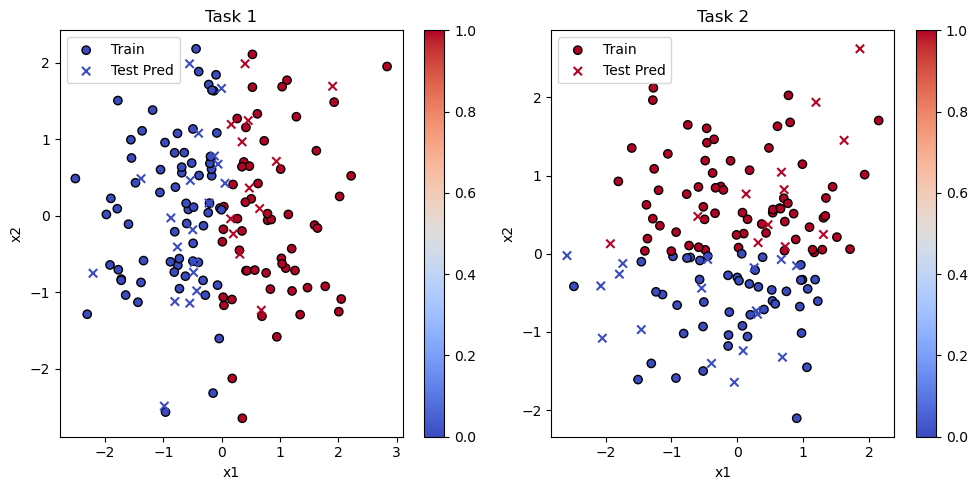

In [12]:
def plot_multi_output_gpc(model, X_train, task_train, y_train, X_test, task_test, y_test, num_tasks):
    """
    Visualize the predictions of the multi-output GP classifier using CoregionalizeKernel.

    Args:
        model: Trained multi-output GP classifier.
        X_train: Training input features (tensor).
        task_train: Task indices for training data (tensor).
        y_train: Training target labels (tensor).
        X_test: Test input features (tensor).
        task_test: Task indices for test data (tensor).
        y_test: Test target labels (tensor).
        num_tasks: Total number of tasks.
    """
    model.eval()
    with torch.no_grad():
        probs = model.predict(X_test, task_test)

    X_train = X_train.cpu()
    X_test = X_test.cpu()
    task_train = task_train.cpu()
    task_test = task_test.cpu()
    y_train = y_train.cpu()
    y_test = y_test.cpu()
    probs = probs.cpu()

    plt.figure(figsize=(5 * num_tasks, 5))
    for i in range(num_tasks):
        plt.subplot(1, num_tasks, i + 1)

        # Train points
        plt.scatter(
            X_train[task_train == i][:, 0],
            X_train[task_train == i][:, 1],
            c=y_train[task_train == i],
            cmap='coolwarm',
            edgecolor='k',
            label='Train'
        )

        # Test predictions (using predicted probabilities thresholded at 0.5)
        test_probs = probs[task_test == i]
        test_pred = (test_probs > 0.5).float()

        plt.scatter(
            X_test[task_test == i][:, 0],
            X_test[task_test == i][:, 1],
            c=test_pred,
            cmap='coolwarm',
            marker='x',
            label='Test Pred'
        )

        plt.title(f"Task {i + 1}")
        plt.colorbar()
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_multi_output_gpc(
    model=trained_model,
    X_train=X_train,
    task_train=task_train_split,
    y_train=y_train,
    X_test=X_test,
    task_test=task_test_split,
    y_test=y_test,
    num_tasks=num_tasks
)

# Train and Evaluate SVGP Model 

In [ ]:
class RBFKernel(nn.Module):
    def __init__(self, input_dim, lengthscale_init=1.0):
        super().__init__()
        self.log_lengthscale = nn.Parameter(torch.log(torch.tensor(lengthscale_init)))
    
    def forward(self, X1, X2):
        """
        Compute RBF kernel matrix between X1 and X2
        """
        X1 = X1 / self.log_lengthscale.exp()
        X2 = X2 / self.log_lengthscale.exp()
        sqdist = torch.cdist(X1, X2, p=2).pow(2)
        return torch.exp(-0.5 * sqdist)

def train_svgp_classification(model, dataloader, optimizer, full_n, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        for X, T, Y in dataloader:
            optimizer.zero_grad()
            loss = model(X, T, Y, full_n)  # The forward pass calculates the negative ELBO
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Print loss and accuracy every 10 epochs
        if epoch % 10 == 9:
            total_loss /= len(dataloader)
            print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Initialize the model and optimizer
svgp_model = MultiOutputSVGP(input_dim=2, num_tasks=num_tasks, num_inducing=50)
optimizer = torch.optim.Adam(svgp_model.parameters(), lr=0.01)

# Prepare the DataLoader
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train, task_train_split, y_train)),
    batch_size=16,
    shuffle=True
)

# Train the model
train_svgp_classification(svgp_model, train_loader, optimizer, full_n=len(X_train), epochs=100)

Epoch 10, Loss: 3223.8276
Epoch 20, Loss: 1844.1808
Epoch 30, Loss: 1248.6124
Epoch 40, Loss: 930.3022
Epoch 50, Loss: 760.2183
Epoch 60, Loss: 640.4026
Epoch 70, Loss: 541.7894
Epoch 80, Loss: 480.4475
Epoch 90, Loss: 431.5013
Epoch 100, Loss: 388.1711


In [15]:
def evaluate_svgp_classification(model, X_test, T_test, y_test):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for evaluation
        # Make predictions
        prob_test, _ = model.predict(X_test, T_test)  # Predict class probabilities
        
        # Apply threshold to get predicted labels (0 or 1)
        predicted = (prob_test >= 0.5).float()

        # Compute accuracy
        accuracy = (predicted.squeeze() == y_test).float().mean().item()
        print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the model on the test set
evaluate_svgp_classification(svgp_model, X_test, task_test_split, y_test)

Test Accuracy: 0.8167
